In [67]:
#Best Parameters (based on external validation): {'n_components': 81, 'penalizer': 0.5, 'l1_ratio': 0, 'mean_cv_cindex': np.float64(0.6658462281171713), 'external_cindex': np.float64(0.5506849315068493)}
#Best External C-index: 0.5506849315068493

In [68]:
#Best Parameters (based on external validation): {'n_components': 3, 'penalizer': 0.1, 'l1_ratio': 0.9, 'mean_cv_cindex': np.float64(0.569), 'external_cindex': np.float64(0.6712328767123288)}
#Best External C-index: 0.6712328767123288

In [69]:
import pandas as pd
import numpy as np
from lifelines import NelsonAalenFitter
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random
from neurocombat_sklearn import CombatModel
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

SEED = 3
random.seed(SEED)
np.random.seed(SEED)

# Load the datasets
train_df = pd.read_csv("UROMOL_TaLG_teachingcohort.csv")
train_df = train_df.dropna()
external_df = pd.read_csv("knowles_matched_TaLG_final.csv")
print(train_df.shape)
print(external_df.shape)
common_clinical_features = ["Age", "Sex", "Concomitant.CIS", "BCG", "UROMOL2021.classification","RFS_time", "Recurrence"]

(191, 33214)
(77, 20293)


# Preprocessing

In [70]:
train_clinical = pd.get_dummies(train_df[common_clinical_features], drop_first=False)
external_clinical = pd.get_dummies(external_df[common_clinical_features], drop_first=False)
external_clinical = external_clinical.reindex(columns=train_clinical.columns, fill_value=0)

In [71]:
pcs = 3
penalize = 0.1
ratio=0.9

In [72]:
#pcs = 1
#penalize = 5
#ratio=0

In [73]:
# Identify gene expression columns in both datasets
gene_expr_cols_train = [col for col in train_df.columns if col.startswith("exprs.")]
gene_expr_cols_ext = [col for col in external_df.columns if col.startswith("exprs.")]
common_expr_cols = list(set(gene_expr_cols_train).intersection(gene_expr_cols_ext))

# Extract gene expression data
train_expr_scaled = train_df[common_expr_cols].copy()
external_expr_scaled = external_df[common_expr_cols].copy()

# Apply PCA
pca = PCA(n_components=pcs, random_state=SEED)
train_pca = pca.fit_transform(train_expr_scaled)
external_pca = pca.transform(external_expr_scaled)

# Create DataFrames for PCA components
pca_columns = [f"PCA_{i+1}" for i in range(train_pca.shape[1])]
train_pca_df = pd.DataFrame(train_pca, columns=pca_columns, index=train_df.index)
external_pca_df = pd.DataFrame(external_pca, columns=pca_columns, index=external_df.index)

train_final = pd.concat([train_clinical.reset_index(drop=True),train_pca_df.reset_index(drop=True)], axis=1).dropna()
external_final = pd.concat([external_clinical.reset_index(drop=True),external_pca_df.reset_index(drop=True)], axis=1).dropna()

# Fitting

In [74]:
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
cindex_scores = []
fold = 1
for train_index, val_index in kf.split(train_final):
    train_cv = train_final.iloc[train_index].copy()
    val_cv = train_final.iloc[val_index].copy()
    
    # Train Cox model on training fold
    cph_cv = CoxPHFitter(penalizer=penalize,l1_ratio=ratio)
    cph_cv.fit(train_cv, duration_col="RFS_time", event_col="Recurrence")

    fold_cindex = cph_cv.score(val_cv, scoring_method="concordance_index")
    cindex_scores.append(fold_cindex)
        
    print(f"Fold {fold} C-index: {fold_cindex:.3f}")
    fold += 1

avg_cindex = np.mean(cindex_scores)
std_cindex = np.std(cindex_scores)
print(f"Average 5-Fold CV C-index: {avg_cindex:.2f} ± {std_cindex:.2f}")

Fold 1 C-index: 0.567
Fold 2 C-index: 0.511
Fold 3 C-index: 0.627
Fold 4 C-index: 0.599
Fold 5 C-index: 0.538
Average 5-Fold CV C-index: 0.57 ± 0.04


In [75]:
cph_final = CoxPHFitter(penalizer=penalize,l1_ratio=ratio)
cph_final.fit(train_final, duration_col="RFS_time", event_col="Recurrence")

<lifelines.CoxPHFitter: fitted with 191 total observations, 55 right-censored observations>

# Plots

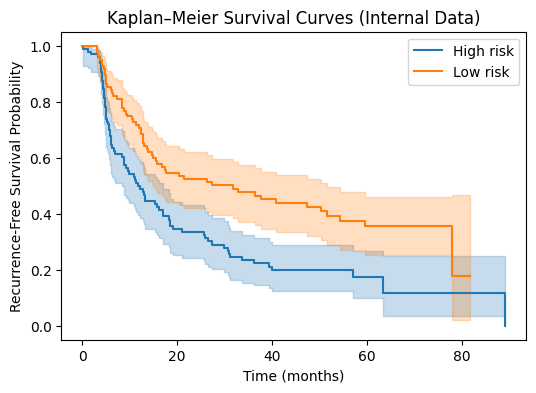

External Log-rank test p-value: 0.0004583657738361768


In [76]:
train_final["risk_score"] = cph_final.predict_partial_hazard(train_final)
median_risk_ext = train_final["risk_score"].median()
train_final["risk_group"] = train_final["risk_score"].apply(
    lambda x: "High risk" if x >= median_risk_ext else "Low risk"
)

# Kaplan-Meier curves for external data
kmf = KaplanMeierFitter()
plt.figure(figsize=(6, 4))
for group in ["High risk", "Low risk"]:
    ix = train_final["risk_group"] == group
    kmf.fit(train_final.loc[ix, "RFS_time"], train_final.loc[ix, "Recurrence"], label=group)
    kmf.plot_survival_function(ci_show=True)
plt.title("Kaplan–Meier Survival Curves (Internal Data)")
plt.xlabel("Time (months)")
plt.ylabel("Recurrence-Free Survival Probability")
plt.show()

# Log-rank test for external data
high_ext = train_final[train_final["risk_group"] == "High risk"]
low_ext = train_final[train_final["risk_group"] == "Low risk"]
logrank_ext = logrank_test(high_ext["RFS_time"], low_ext["RFS_time"],
                           event_observed_A=high_ext["Recurrence"],
                           event_observed_B=low_ext["Recurrence"])
print("External Log-rank test p-value:", logrank_ext.p_value)

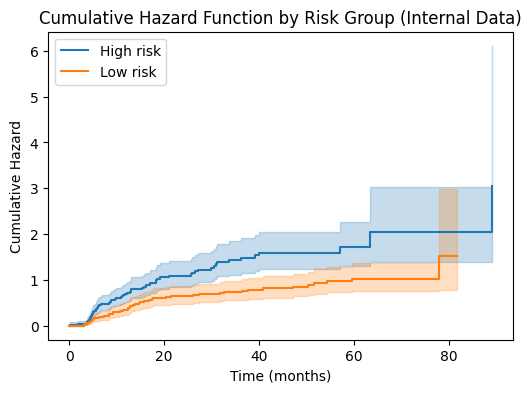

In [82]:
naf = NelsonAalenFitter()

plt.figure(figsize=(6, 4))
for group in ["High risk", "Low risk"]:
    # Subset your DataFrame by risk group
    ix = train_final["risk_group"] == group
    
    # Fit the Nelson–Aalen cumulative hazard for that subgroup
    naf.fit(
        train_final.loc[ix, "RFS_time"],
        event_observed=train_final.loc[ix, "Recurrence"],
        label=group
    )
    
    # Plot the cumulative hazard function
    naf.plot(ci_show=True)  # ci_show=True will plot confidence intervals if available

plt.title("Cumulative Hazard Function by Risk Group (Internal Data)")
plt.xlabel("Time (months)")
plt.ylabel("Cumulative Hazard")
plt.legend()
plt.show()

External Concordance Index: 0.67


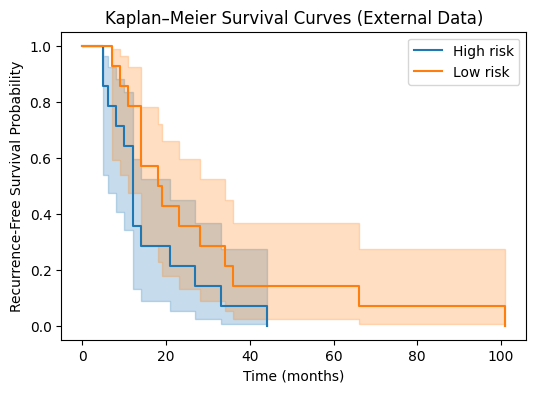

External Log-rank test p-value: 0.08673130005156392


In [78]:
external_final["risk_score"] = cph_final.predict_partial_hazard(external_final)
median_risk_ext = external_final["risk_score"].median()
external_final["risk_group"] = external_final["risk_score"].apply(
    lambda x: "High risk" if x >= median_risk_ext else "Low risk"
)

external_cindex = cph_final.score(external_final, scoring_method="concordance_index")
print(f"External Concordance Index: {external_cindex:.2f}")


# Kaplan-Meier curves for external data
kmf = KaplanMeierFitter()
plt.figure(figsize=(6, 4))
for group in ["High risk", "Low risk"]:
    ix = external_final["risk_group"] == group
    kmf.fit(external_final.loc[ix, "RFS_time"], external_final.loc[ix, "Recurrence"], label=group)
    kmf.plot_survival_function(ci_show=True)
plt.title("Kaplan–Meier Survival Curves (External Data)")
plt.xlabel("Time (months)")
plt.ylabel("Recurrence-Free Survival Probability")
plt.show()

# Log-rank test for external data
high_ext = external_final[external_final["risk_group"] == "High risk"]
low_ext = external_final[external_final["risk_group"] == "Low risk"]
logrank_ext = logrank_test(high_ext["RFS_time"], low_ext["RFS_time"],
                           event_observed_A=high_ext["Recurrence"],
                           event_observed_B=low_ext["Recurrence"])
print("External Log-rank test p-value:", logrank_ext.p_value)

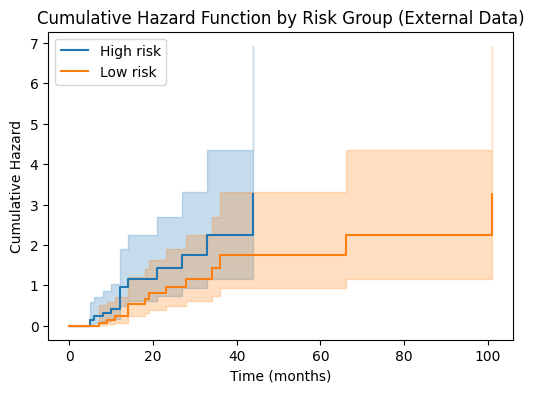

In [79]:
naf = NelsonAalenFitter()

plt.figure(figsize=(6, 4))
for group in ["High risk", "Low risk"]:
    # Subset your DataFrame by risk group
    ix = external_final["risk_group"] == group
    
    # Fit the Nelson–Aalen cumulative hazard for that subgroup
    naf.fit(
        external_final.loc[ix, "RFS_time"],
        event_observed=external_final.loc[ix, "Recurrence"],
        label=group
    )
    
    # Plot the cumulative hazard function
    naf.plot(ci_show=True)  # ci_show=True will plot confidence intervals if available

plt.title("Cumulative Hazard Function by Risk Group (External Data)")
plt.xlabel("Time (months)")
plt.ylabel("Cumulative Hazard")
plt.legend()
plt.show()

ICI =  0.15167551886450972
E50 =  0.14810217912178258
ICI =  0.08352854596300688
E50 =  0.09068546170717134
ICI =  0.1026158500836905
E50 =  0.11006971702014862
ICI =  0.01708876396959969
E50 =  0.02085673010352046


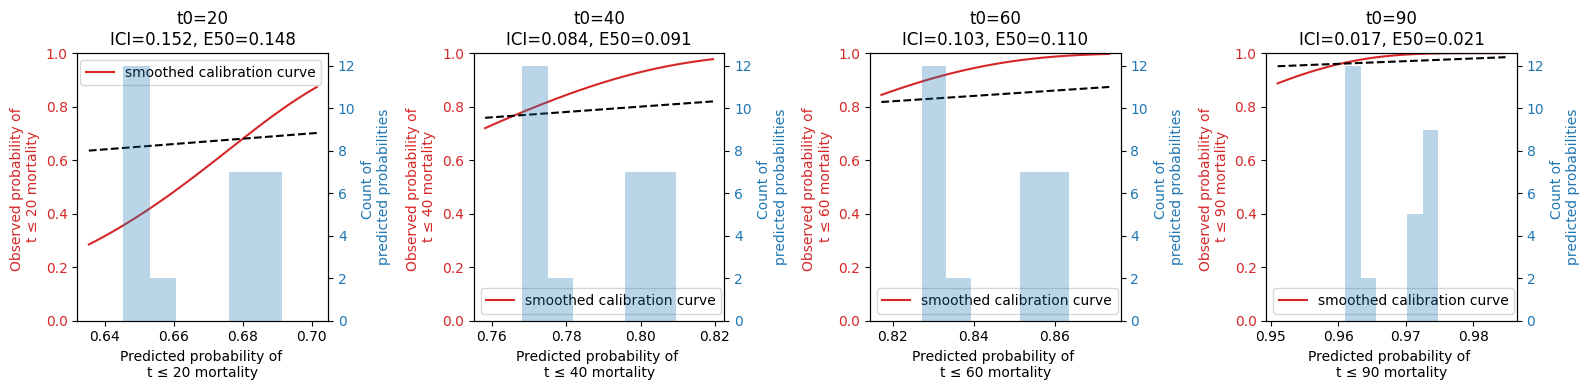

In [80]:
import matplotlib.pyplot as plt
from lifelines.calibration import survival_probability_calibration

# Define the time points you want to plot
time_points = [20, 40, 60, 90]

# Create a single row of subplots (1 row, 4 columns)
fig, axes = plt.subplots(1, len(time_points), figsize=(16, 4))

# Loop over the time points and plot each calibration curve
for ax, t in zip(axes, time_points):
    ax, ICI, E50 = survival_probability_calibration(cph_final, external_final, t0=t, ax=ax)
    ax.set_title(f"t0={t}\nICI={ICI:.3f}, E50={E50:.3f}")
    ax.set_ylim(0, 1)  # Set the y-axis limits

plt.tight_layout()
plt.show()

<Axes: xlabel='log(HR) (95% CI)'>

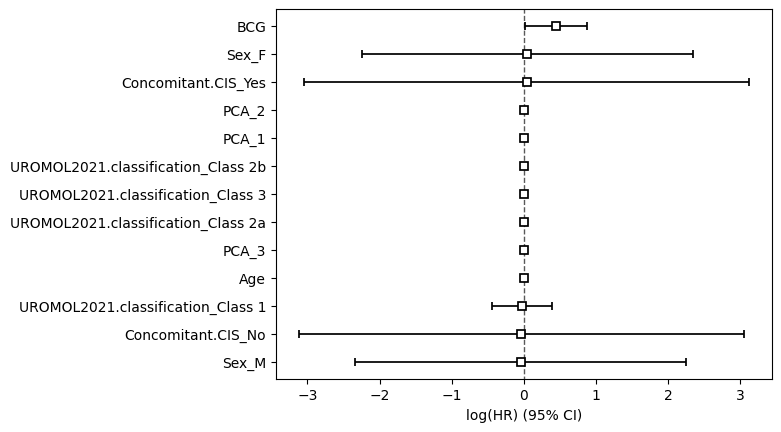

In [81]:
cph_final.plot()